In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nglview as ng
import numpy as np
import MDAnalysis as mda
import pandas as pd

from scipy import integrate

from util import tower_sample, cum_hist

# Look at Chain Length Distribution

As a first step we will look just at the pure theoretical expected distrubution for a particle in 3 dimension. The first part also contains some helper functions.

In [2]:
class ChainPDF:
    @staticmethod
    def one_dim(x, end_dist=3.81):
        RR = end_dist**2
        return (1.5 / (np.pi * RR))**(1.5) * np.exp(-1.5 * x**2 / RR)

    @staticmethod
    def three_dim (x, end_dist=3.81):
        return 4*np.pi*x**2 * ChainPDF.one_dim(x, end_dist=end_dist)
    
def cumulative(pdf):
    pdf = np.asarray(pdf)
    cumsum = pdf.cumsum()
    return cumsum / cumsum[-1]

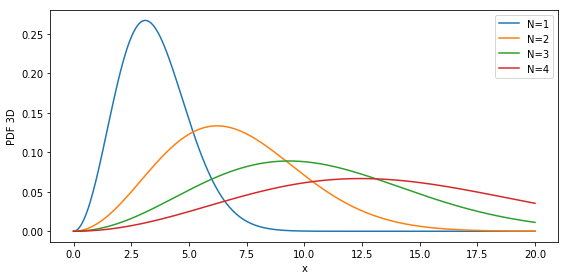

In [3]:
f, ax1 = plt.subplots(1, 1, figsize=plt.figaspect(.5))
x = np.linspace(0, 20, num=500)


for i in range(1, 5):
    ax1.plot(x, ChainPDF.three_dim(x, end_dist=3.81 * i), label='N={}'.format(i))

ax1.set(xlabel='x', ylabel='PDF 3D')
ax1.legend(loc='best')

plt.tight_layout()

This plot shows the probability distribution for the end-to-end distance for 1 to 4 beads.

Next we are using cumulative histograms to compare the distributions of the distances when we use tower sampling like in complexes. The use of cumulative histograms makes the normalizing vary nice and we don't need to specify any binning (also no binning artefacts).

In [4]:
xmin = 3.81
xmax = 9
bins = 400
dx = 0.05

x = np.arange(bins) * dx 

sample = tower_sample(ChainPDF.three_dim, x.min(), x.max(), size=10000, 
                      n_grid=bins)
#x = np.linspace(xmin, xmax, bins)

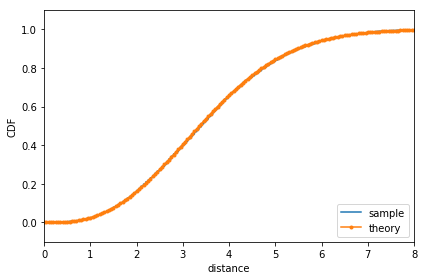

In [6]:
f, ax = plt.subplots()
cum_hist(sample, ax=ax, label='sample')
ax.plot(x, cumulative(ChainPDF.three_dim(x)), '.-', label='theory')
ax.set(xlabel='distance', ylabel='CDF', ylim=(-.1, 1.1), xlim=(0, 8))
ax.legend(loc='lower right')
plt.tight_layout()

This is the cumulative distribution for a sample of lengths between 3.81 and 5 Angström. Both curves fir together nicely.
In the sample there is a binning effect visible. But that one comes from the `dx` resolution chosen to resolve the original distribution. If I decrease that value the curve will be smoother.

In [11]:
def end2end(N, xmin=0, xmax=20, R=3.81):
    # R = 3.81  # distance between two beads
    x = np.linspace(xmin, xmax, num=2000)
    pdf = ChainPDF.three_dim(x, R * N)
    
    # normalize pdf so cdf is between 0 and 1
    pdf /= integrate.simps(pdf, x=x)
    
    return integrate.simps(pdf * x, x=x)

In [12]:
end2end(1)

3.510220536736865

# Do complexes simulations of only the gaussian chain between to non moving rigid beads

Now we will simulate various length gaussian chains where we vary the distance and the number of beads used at each distance. For all of this the end-to-end distance will be varied around the optional end-to-end distance of a gaussian chain.

In [13]:
%%writefile input.top
box: [9000, 9000, 9000]
topology:
   Binding:
       coordinate-file: deca-ala.pdb
       domains:
         1r_beginning:
           type: rigid
           selection: 'name CA and resid 1'
         2r_end:
           type: rigid
           selection: 'name CA and resid 10'
         3deca_ala:
           type: gaussian
           selection: 'name CA and resid 2:9'
           mc-moves:
             interact: False
       connections:
         0:
           domain-a: [1r_beginning, B 1]
           domain-b: [3deca_ala, B 2]
           type: flat
           params: {}
         1:
           domain-a: [3deca_ala, B 9]
           domain-b: [2r_end, B 10]
           type: flat
           params: {}
         2:
           domain-a: [1r_beginning, B 1]
           domain-b: [2r_end, B 10]
           type: gaussian
           params: {N: 8, bond-length: 3.81}


Overwriting input.top


In [14]:
!pycomplexes convert input.top structure.cplx --random=True

In [15]:
%%writefile sim.conf
structure: structure.cplx
montecarlo:
    algorithm: nvt
    algorithm-params:
      rot: 0.1
      trans: 1
      accept-func: metropolis
      temperatur: 400
    seed: 4743
    initial-position:
     strategy: init-no-collision
     max-attemps-per-domain: 1000
    short-range-cutoff:
        enable: False
output:
   log: complexes.log
   file: production.xtc
   freq: 5
   nstructures: 5000
   stat-file: production.stat
   restart-freq: -1

Overwriting sim.conf


In [16]:
%%bash 
# filter away noisy output see above
complexes++ --config=sim.conf --backup=False

[LOG] forcefield folder: /home/max/academia/projects/complexes/complexes++/forcefields/complexes08_lambda0.159_epsilon-2.27
[LOG] 
[LOG] #######################
[LOG] # PROGRAM INFORMATION #
[LOG] #######################
[LOG] name: Complexes++
[LOG] version: 0.4pre
[LOG] commit: fce1038e752b45b4da98461c47205c30cfbb2f82
[LOG] compilation flags:  -Wall -Wextra -Wshadow -Wnon-virtual-dtor -pedantic -Woverloaded-virtual -Wpointer-arith -Wcast-qual -Wconversion -Wno-sign-conversion -Wold-style-cast -fopenmp=libomp -Werror  -mavx2 -march=native -mavx -march=native -msse4 -msse4.2 -march=native -msse4 -msse4.1 -march=native -mssse3 -march=native -msse3 -march=native -Wold-style-cast
[LOG] compilation libs: /home/max/academia/projects/complexes/complexes++/build/release/ext/xdrfile-1.1.4/1.1.4/lib/libxdrfile.a;/usr/lib/libyaml-cpp.so;/usr/lib/libfmt.a;/usr/lib/libnetcdf_c++4.so;/usr/lib/libnetcdf.so;/usr/lib/libhdf5_hl.so;/usr/lib/libhdf5.so;/usr/lib/libz.so;/usr/lib/libdl.so;/usr/lib/libboos

For  a quick check how the trajectory looks we can use nglview

In [17]:
u = mda.Universe('production_reference.pdb', 'production.xtc')

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [18]:
def neighbor_distance(ag):
    p = ag.positions
    return np.linalg.norm(p[1:] - p[:-1], axis=1)

def get_pair_distances(atoms):
    _p = atoms.positions.copy()

    d = []
    for i, ts in enumerate(atoms.universe.trajectory):
        # avoid counting if positions haven't changed in the chain
        if not np.allclose(atoms.positions, _p):
            d.append(neighbor_distance(atoms))
        _p = atoms.positions.copy()

    d = np.array(d)
    return d

To check the distribution of next-neighbor distance we have to extract them from the trajectory. We exclude residue 1 and 10 because they are not part of the linker.

In [19]:
linker = u.select_atoms('resid 2:9')
distances = get_pair_distances(linker)

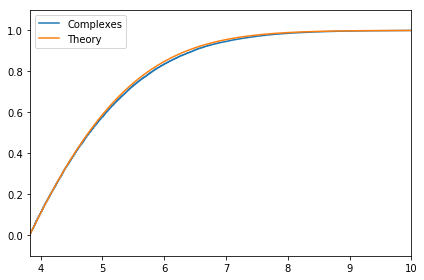

In [21]:
f, ax = plt.subplots()
cum_hist(distances.ravel(), ax=ax, label='Complexes')

x = np.linspace(distances.min(), distances.max(), 1000)
ax.plot(x, cumulative(ChainPDF.three_dim(x)), label='Theory')

ax.set(ylim=(-.1, 1.1), xlim=(distances.min(), 10), yscale='linear')

ax.legend(loc='best')

plt.tight_layout()

The differences to the theory are because the distance at which we keep the rigid domains fixed is a bit shorter then the ideal distance for the gaussian chain.

# Distribution check without overlap check

The above distribution will have slight deviations from the ideal because we do an overlap check that is enabled by default. Deactivating it should yield a better aggrement

In [25]:
import yaml

In [38]:
with open('structure.cplx') as fh:
    cplx = yaml.load(fh)

cplx['definitions']['domains']['gaussian']['defaults']['collision-check'] = False
cplx['definitions']['domains']['gaussian']['defaults']['self-collision-check'] = False

with open('structure-collisions.cplx', 'w') as fh:
    yaml.dump(cplx, fh)

In [43]:
%%writefile sim-collision.conf
structure: structure-collisions.cplx
montecarlo:
    algorithm: nvt
    algorithm-params:
      rot: 0.1
      trans: 1
      accept-func: metropolis
      temperatur: 400
    seed: 4743
    initial-position:
     strategy: init-no-collision
     max-attemps-per-domain: 1000
    short-range-cutoff:
        enable: False
output:
   log: complexes.log
   file: production-collision.xtc
   freq: 5
   nstructures: 5000
   stat-file: production-collision.stat
   restart-freq: -1

Overwriting sim-collision.conf


In [44]:
!complexes++ -c sim-collision.conf --backup=false --nb-thread=1

[LOG] forcefield folder: /home/max/academia/projects/complexes/complexes++/forcefields/complexes08_lambda0.159_epsilon-2.27
[LOG] 
[LOG] #######################
[LOG] # PROGRAM INFORMATION #
[LOG] #######################
[LOG] name: Complexes++
[LOG] version: 0.4pre
[LOG] commit: fce1038e752b45b4da98461c47205c30cfbb2f82
[LOG] compilation flags:  -Wall -Wextra -Wshadow -Wnon-virtual-dtor -pedantic -Woverloaded-virtual -Wpointer-arith -Wcast-qual -Wconversion -Wno-sign-conversion -Wold-style-cast -fopenmp=libomp -Werror  -mavx2 -march=native -mavx -march=native -msse4 -msse4.2 -march=native -msse4 -msse4.1 -march=native -mssse3 -march=native -msse3 -march=native -Wold-style-cast
[LOG] compilation libs: /home/max/academia/projects/complexes/complexes++/build/release/ext/xdrfile-1.1.4/1.1.4/lib/libxdrfile.a;/usr/lib/libyaml-cpp.so;/usr/lib/libfmt.a;/usr/lib/libnetcdf_c++4.so;/usr/lib/libnetcdf.so;/usr/lib/libhdf5_hl.so;/usr/lib/libhdf5.so;/usr/lib/libz.so;/usr/lib/libdl.so;/usr/lib/libboos

## Nearest Neighbor interactions

In [45]:
u = mda.Universe('production-collision_reference.pdb', 'production-collision.xtc')

In [46]:
linker = u.select_atoms('resid 2:9')
distances = get_pair_distances(linker)

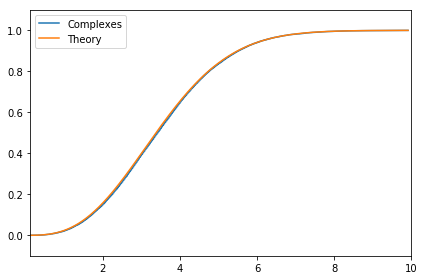

In [47]:
f, ax = plt.subplots()
cum_hist(distances.ravel(), ax=ax, label='Complexes')

x = np.linspace(distances.min(), distances.max(), 1000)
ax.plot(x, cumulative(ChainPDF.three_dim(x)), label='Theory')

ax.set(ylim=(-.1, 1.1), xlim=(distances.min(), 10), yscale='linear')

ax.legend(loc='best')

plt.tight_layout()

In [48]:
from scipy import stats

In [64]:
complexes_pdf, bins = np.histogram(distances.ravel(), bins=50, normed=True)
bins = bins[:-1] + .5 * (bins[1] - bins[0])
theory_pdf = ChainPDF.three_dim(bins)

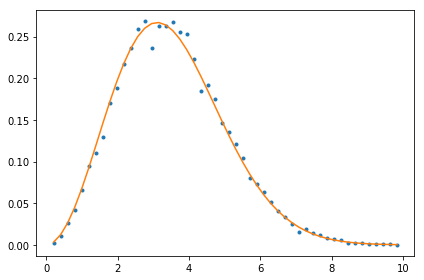

In [65]:
fig, ax = plt.subplots()

ax.plot(bins, complexes_pdf, '.')
#ax.hist(distances.ravel(), bins=50, normed=True)
ax.plot(bins, theory_pdf)

fig.tight_layout()

In [66]:
stats.entropy(complexes_pdf, theory_pdf)

0.0016603846789162305

## End to End distance

Because the actual end to end particles interact with each other using a Lennard jones type interaction we are going to use the beginning and end of the gaussian chain definition to look at the end to end distance.

In [98]:
e2e = []
for ts in u.trajectory:
    e2e.append(np.linalg.norm(u.atoms[2].position - u.atoms[-1].position))
e2e = np.asarray(e2e)

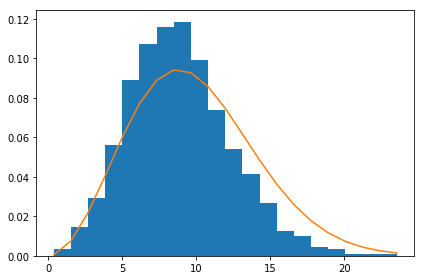

In [100]:
fig, ax = plt.subplots()

_, bins, _ = ax.hist(e2e, bins=20, normed=True, label='Simulation')
ax.plot(bins, ChainPDF.three_dim(bins, end_dist=3.81 * np.sqrt(8)))

fig.tight_layout()

This is off and might go away to longer chains.